In [512]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
from matplotlib import ticker

import representation
import kex_data
import kex_headers
import listmode
import petlink
import position

In [2]:
#get the raw listmode data
limo_dset, limo_paths = kex_data.listmode()
phantom_keys = ["cylinder", "cannula"]
gate_keys = ["0", "1"]
keys = []
for p_key in phantom_keys:
    for g_key in gate_keys:
        keys.append(" ".join([p_key, "gate", g_key]))
limo_dict = dict(zip(keys, limo_dset))

In [541]:
#listmode reconstruction to image space
print("documentation\n", listmode.get_fov_image_bins.__doc__)
img_dict = {key: listmode.get_fov_image_bins(limo_dict[key]) for key in keys}

documentation
  get fov_image_bins: the pipeline from listmode to fov image bin
    input: petlink listmode_data, and keyvalue argumnts for representation.get_image_bins
    return dictionary with: is_event, events, tof_lor, is_prompt, prompts,  prompt_image_bins, is_image_fov, fov_image_bins  


In [542]:
#normalized and random corrected weight per prompt event 
norm_sinos, _ = kex_data.get_norm_factors()
norm_dict = dict(zip(keys,norm_sinos))
print("documentation\n",listmode.get_norms.__doc__)
mass_dict = {key: listmode.get_norms(img_dict[key]['tof_lor'], 
                                     img_dict[key]['is_prompt'],
                                     norm_dict[key]) 
             for key in keys}
fov_mass_dict = {key: mass_dict[key][img_dict[key]['is_image_fov']] for key in keys}

documentation
  get_norms: return a list of masses with correction factor per event including normalization and random correction (averaged over scan) 
    input: tof_lor_bins, is_prompt, normfactors
    return mass_list 


In [543]:
#get center of mass
print("documentation\n", position.listmode_center.__doc__)
limo_com = {key: position.listmode_center(listmode_data=img_dict[key]['fov_image_bins'],
                                         axis=1,
                                         masses=fov_mass_dict[key])
           for key in keys}

documentation
  listmode_center: calculate Center of mass of 2D numpy array with dimension coordinates. Points listed along axis.
        input: listmode, axis=1, masses=None
        if no masses provided, mass of 1 for all points is assumed
        return center_of_mass


In [197]:
# get reference com
osem, _ = kex_data.reconstructions()
osem_dict = dict(zip(keys, osem))
osem_com = {key: position.center_of_mass(osem_dict[key]) for key in keys}

In [544]:
from tabulate import tabulate
print("documentation\n",tabulate.__doc__)

documentation
 Format a fixed width table for pretty printing.

    >>> print(tabulate([[1, 2.34], [-56, "8.999"], ["2", "10001"]]))
    ---  ---------
      1      2.34
    -56      8.999
      2  10001
    ---  ---------

    The first required argument (`tabular_data`) can be a
    list-of-lists (or another iterable of iterables), a list of named
    tuples, a dictionary of iterables, an iterable of dictionaries,
    a two-dimensional NumPy array, NumPy record array, or a Pandas'
    dataframe.


    Table headers
    -------------

    To print nice column headers, supply the second argument (`headers`):

      - `headers` can be an explicit list of column headers
      - if `headers="firstrow"`, then the first row of data is used
      - if `headers="keys"`, then dictionary keys or column indices are used

    Otherwise a headerless table is produced.

    If the number of headers is less than the number of columns, they
    are supposed to be names of the last columns. This is co

In [546]:
#make table
head = ["phantom", "gate", "reconstruction", "z", "y", "x"]
recon_keys = ["OP-OSEM", "listmode"]
com_dict = dict(zip(recon_keys, [osem_com, limo_com]))
rows = []
space = [""]
for scan_key in keys:
    key_parts = scan_key.split(" gate ")
    rows.append(key_parts)
    for r_key in recon_keys:
        #print(key)
        
        #print(key.split(" gate "))
        #print(r_key)
        row = space*2 + [r_key] + list(com_dict[r_key][scan_key])
        #print(row)
        rows.append(row)
        
print("center of mass table\n", tabulate(rows,headers=head, floatfmt=".2f"))

center of mass table
 phantom    gate    reconstruction        z       y       x
---------  ------  ----------------  -----  ------  ------
cylinder   0
                   OP-OSEM           54.55   99.88  100.24
                   listmode          54.27   99.91  100.26
cylinder   1
                   OP-OSEM           54.48  109.81  100.20
                   listmode          54.25  109.12  100.20
cannula    0
                   OP-OSEM           47.50  120.45   99.07
                   listmode          47.93  120.03   99.15
cannula    1
                   OP-OSEM           47.54  137.43   99.01
                   listmode          47.92  136.74   99.00


In [545]:
#for latex
print("latex tabular\n", tabulate(rows,floatfmt=".2f", tablefmt='latex'))

latex tabular
 \begin{tabular}{lllrrr}
\hline
 cylinder & 0 &          &       &        &        \\
          &   & OP-OSEM  & 54.55 &  99.88 & 100.24 \\
          &   & listmode & 54.27 &  99.91 & 100.26 \\
 cylinder & 1 &          &       &        &        \\
          &   & OP-OSEM  & 54.48 & 109.81 & 100.20 \\
          &   & listmode & 54.25 & 109.12 & 100.20 \\
 cannula  & 0 &          &       &        &        \\
          &   & OP-OSEM  & 47.50 & 120.45 &  99.07 \\
          &   & listmode & 47.93 & 120.03 &  99.15 \\
 cannula  & 1 &          &       &        &        \\
          &   & OP-OSEM  & 47.54 & 137.43 &  99.01 \\
          &   & listmode & 47.92 & 136.74 &  99.00 \\
\hline
\end{tabular}


In [202]:
#convert "listmode images" to normal images
limo_images = {key: listmode.get_histogram(
                            img_dict[key]['fov_image_bins'], 
                            kex_headers.IMAGE_SHAPE, 
                            weights=fov_mass_dict[key]) 
               for key in keys}

In [532]:
def same_colorbar(fig, images, axes, nbins=5):
    """ make a shared colorbar that applies to the images on the axes. 
    The colorbar has up to nbins ticks"""
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images: 
        im.set_norm(norm)
    cb = fig.colorbar(images[0], ax=axes)
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cb.locator = tick_locator
    cb.update_ticks()

In [537]:
def plot_data(images,shape,saveto=None,aspect=1,figsize=None,fontsize='x-large',ticknum=5,dim=0):    
    nrows,ncols = shape
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)
    positions = {key: (k // nrows, k%ncols) for k, key in enumerate(keys)}
    ax_images = []
    dims = np.arange(3)
    dims = dims[dims != dim]
    for key in images:
        pos = positions[key]
        ax = axes[pos]
        ax_images.append(ax.imshow(images[key], aspect=aspect))
        ax.set_title(key, fontsize=fontsize)
        dim_titles = [kex_headers.IMAGE_DIMENSION_TITLES[d] for d in dims]
        ax.set_ylabel(dim_titles[0]+" pixel", fontsize=fontsize)
        ax.set_xlabel(dim_titles[1]+" pixel", fontsize=fontsize)
        width = kex_headers.IMAGE_SHAPE[1]
        xlim = np.array(ax.get_xlim())+0.5
        ylim = np.array(ax.get_ylim())+0.5
        ax.set_xticks(np.linspace(min(xlim),max(xlim), ticknum+1, dtype=int)[:-1])
        ax.set_yticks(np.linspace(min(ylim),max(ylim), ticknum+1, dtype=int)[:-1])
        ax.tick_params(axis='both', labelsize=kwargs["fontsize"])
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    same_colorbar(fig, ax_images[:2], axes[0])
    same_colorbar(fig, ax_images[2:], axes[1])
    if saveto is not None:
        plt.savefig(fname=saveto) #save before show
    plt.show()

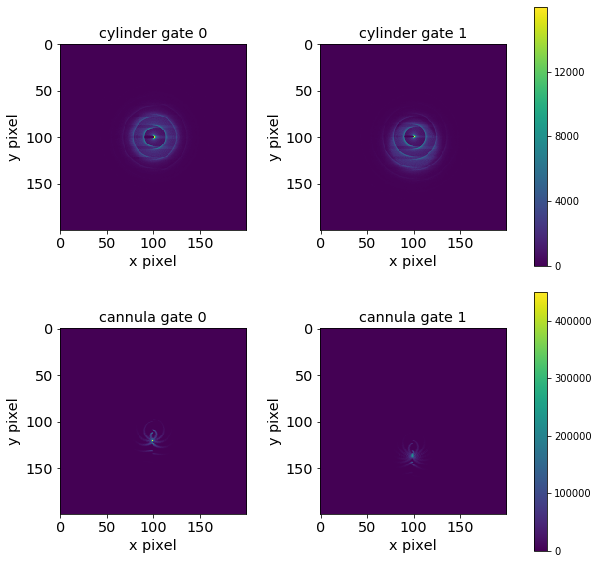

In [547]:
dim=0 #change dimension for different views
image_view = {key: np.sum(limo_images[key], axis=dim) for key in keys}
saveto = 'image_results/gated_recon/listmode_sumaxis'+str(dim)
shape=(2,2)
pixel_mm = kex_headers.MM_PER_PIXEL[np.arange(3) != dim]
aspect = pixel_mm[0] / pixel_mm[1]
hspace = [0.2,0.2,-0.6]
wspace=[0.2,0.2, 0.3]
fraction = [0.15, 0.01, 0.01]
figsize=[(10,10), (10,1), (15,7)]
plot_data(image_view,
          shape,
          saveto,
          figsize=figsize[dim],
          ticknum=4,
          fontsize='x-large',
          aspect=aspect, 
          dim=dim)